<a href="https://colab.research.google.com/github/ipsha5/minor-project/blob/main/Animal%2010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"purbasaaaa","key":"c732afc90e2c00b9dee51031e0b77feb"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [46]:
!kaggle datasets download -d alessiocorrado99/animals10
!unzip animals10.zip -d /content/animal10

Streaming output truncated to the last 5000 lines.
  inflating: /content/animal10/raw-img/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: /content/animal10/raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: /content/animal10/raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: /content/animal10/raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: /content/animal10/raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: /content/animal10/raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: /content/animal10/raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: /content/animal10/raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: /content/animal10/raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: /content/animal10/raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: /content/animal10/raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: /content/animal10/raw-i

In [47]:
import zipfile

zip_data = zipfile.ZipFile('/content/animals10.zip')
zip_data.extractall()
zip_data.close()

# **Image Preprocessing**

Before training a deep learning model, images need to be preprocessed. The key steps include:

- **Resizing & Cropping** - Ensures all images are of the same size.

- **Normalization** - Scales pixel values to [0,1] or [-1,1] to speed up training.

- **Handling Color Channels** - Convert images to RGB (3 channels).

- **Data Augmentation** - Enhances dataset diversity using transformations (flips, rotations, zooms).

In [48]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

In [49]:
folder_path = "/content/raw-img"

shutil.rmtree(folder_path)

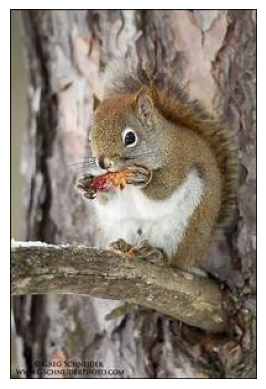

In [50]:
img = cv2.imread('/content/animal10/raw-img/scoiattolo/OIP-xziVYV8vGTFjF4CzDHuipwHaLH.jpeg')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis("off")
plt.show()

In [51]:
import os

# Path to the main folder (change it as needed)
main_folder = "/content/animal10"

# List all subdirectories
subfolders = [f.name for f in os.scandir(main_folder) if f.is_dir()]

print("📂 Subfolder Names:", subfolders)

📂 Subfolder Names: ['raw-img']


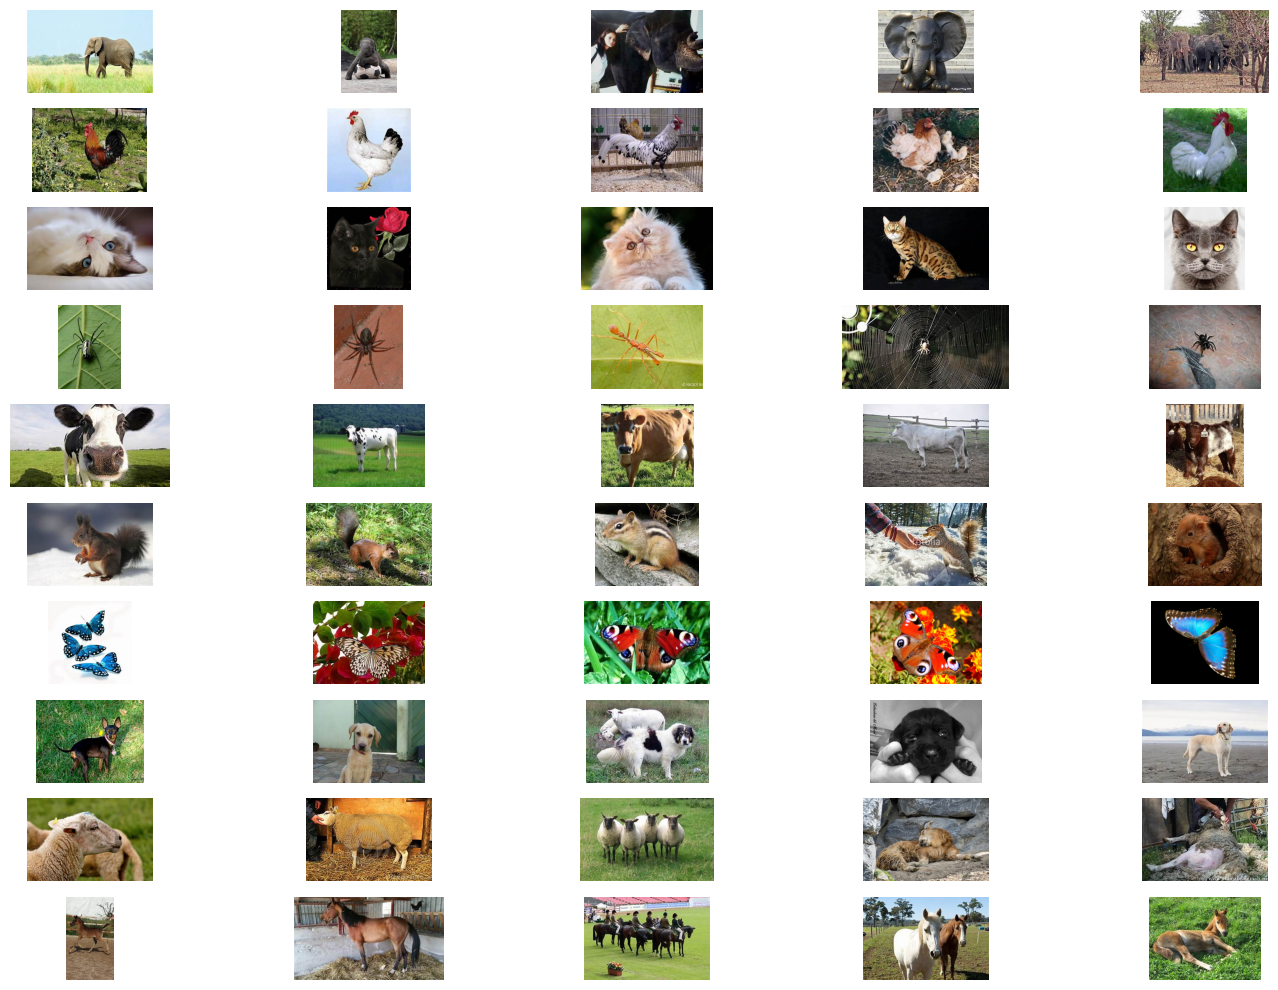

In [52]:
import os
import random
import matplotlib.pyplot as plt
import cv2

def visualize_samples(dataset_path, num_samples=5):
    classes = os.listdir(dataset_path)
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 10))

    for i, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        images = os.listdir(class_path)
        random_images = random.sample(images, min(num_samples, len(images)))

        for j, img_name in enumerate(random_images):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            axes[i, j].imshow(img)
            axes[i, j].axis("off")

        axes[i, 0].set_ylabel(class_name, fontsize=10)

    plt.tight_layout()
    plt.show()

# Call function with dataset path
visualize_samples("/content/animal10/raw-img")

In [54]:
def detect_blur(image_path, threshold=100):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    laplacian_var = cv2.Laplacian(image, cv2.CV_64F).var()

    if laplacian_var < threshold:
        print(f"⚠ Blurry Image Detected: {image_path} (Variance: {laplacian_var:.2f})")
    return laplacian_var

# Example usage
image_path = "/content/animal10/raw-img/scoiattolo/OIP-yYkUFqt3-Luv8yTCWGJF5wHaFq.jpeg"
blur_score = detect_blur(image_path)
print(f"Laplacian Variance Score: {blur_score:.2f}")

Laplacian Variance Score: 1711.14


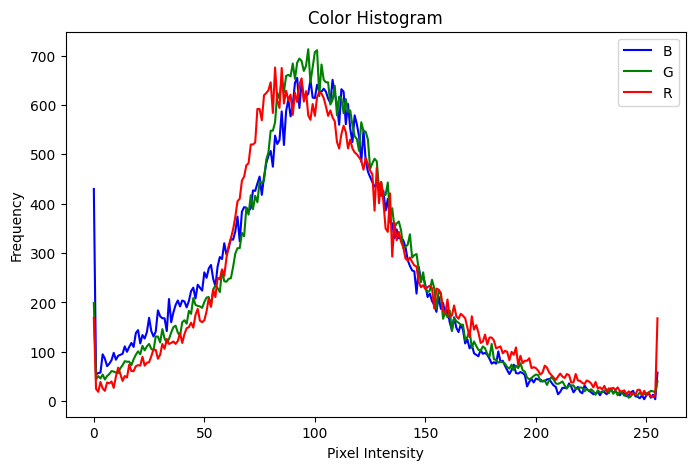

In [55]:
def plot_color_histogram(image_path):
    image = cv2.imread(image_path)
    channels = ('b', 'g', 'r')
    plt.figure(figsize=(8, 5))

    for i, col in enumerate(channels):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=col, label=col.upper())

    plt.title("Color Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Example usage
plot_color_histogram("/content/animal10/raw-img/scoiattolo/OIP-z-1uhOhwztGOqDulrEaKOgHaE7.jpeg")

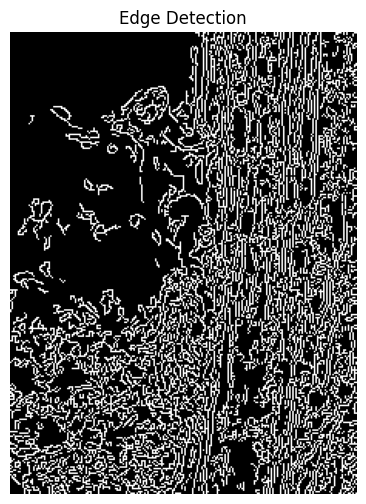

In [56]:
def edge_detection(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(image, 100, 200)

    plt.figure(figsize=(6, 6))
    plt.imshow(edges, cmap='gray')
    plt.title("Edge Detection")
    plt.axis("off")
    plt.show()

# Example usage
edge_detection("/content/animal10/raw-img/scoiattolo/OIP-zBsym6h7uIvfZtE52lwYYAHaJ4.jpeg")

In [57]:
import os

dataset_path = "/content/animal10/raw-img"
categories = [
    'cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo'
]

for category in categories:
    class_path = os.path.join(dataset_path, category)

    # Count only image files (not folders)
    if os.path.exists(class_path) and os.path.isdir(class_path):
        image_count = sum(1 for file in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, file)))
        print(f"\n --> {category.upper()} Set: {image_count} images")
    else:
        print(f"\n --> {category.upper()} Set: Not found")


 --> CANE Set: 4863 images

 --> CAVALLO Set: 2623 images

 --> ELEFANTE Set: 1446 images

 --> FARFALLA Set: 2112 images

 --> GALLINA Set: 3098 images

 --> GATTO Set: 1668 images

 --> MUCCA Set: 1866 images

 --> PECORA Set: 1820 images

 --> RAGNO Set: 4821 images

 --> SCOIATTOLO Set: 1862 images


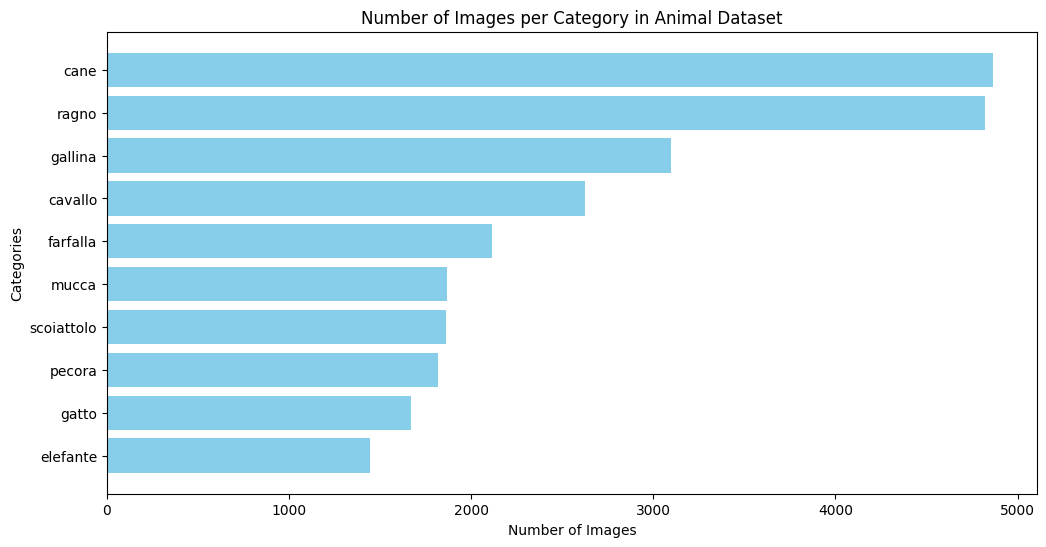

In [58]:
import os
import matplotlib.pyplot as plt

dataset_path = "/content/animal10/raw-img"
categories = [
    'cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo'
]

category_counts = {}

for category in categories:
    class_path = os.path.join(dataset_path, category)

    # Count only image files
    if os.path.exists(class_path) and os.path.isdir(class_path):
        image_count = sum(1 for file in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, file)))
        category_counts[category] = image_count
    else:
        category_counts[category] = 0  # If folder doesn't exist

# Sort categories by count (optional)
category_counts = dict(sorted(category_counts.items(), key=lambda x: x[1], reverse=True))

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(list(category_counts.keys()), list(category_counts.values()), color='skyblue')
plt.xlabel("Number of Images")
plt.ylabel("Categories")
plt.title("Number of Images per Category in Animal Dataset")
plt.gca().invert_yaxis()  # To display highest count on top
plt.show()

In [59]:
import os
print(os.listdir("/content/animal10/raw-img/cane"))

['OIP-Ui0aL3-OxFtBqvJMg-TqzQHaJ4.jpeg', 'OIP-rFyxtoWYc3OFCDoHYLdBugHaE7.jpeg', 'OIP-EuAdaMexob7RwLTlSNQg6gHaFS.jpeg', 'OIP-wugDSDO8WeX1n_biW-gyHAHaF7.jpeg', 'OIP-BAhnDEB-1Y4-FbXETUE15wHaFj.jpeg', 'OIP-MMWmcncK2GhUPLcvSUDYHwHaFW.jpeg', 'OIP-azizj5lWClf77tPu2Ej1JAHaJ3.jpeg', 'OIP-aQrmk0NanExiYjym5D5sKAHaLM.jpeg', 'OIP-W-7zHFceBpZAUA_0EKEp8gHaEK.jpeg', 'OIP-LdYrDU0rNnJn4I-3Z0KRtAHaG-.jpeg', 'OIP-0kv5rMPnEqT_3clDXrKfAQHaHa.jpeg', 'OIP-sXRAeuN1lgEPl43rZQC2tQHaFj.jpeg', 'OIP-19rSogZk5fbKTsnh6DawdwHaJK.jpeg', 'OIP-iePMUJtv2CTr0t7iuQijyAHaEK.jpeg', 'OIP-H3eRjiHJVmYn8qoNCyZATwHaLH.jpeg', 'OIP-sFFjGS6Y3h_dt1g3p1_i-gHaFj.jpeg', 'OIP-Wqc5z9ur06JKxqLNFpA-NwHaF7.jpeg', 'OIP-GkY82Rfn7TdEs_Fs9c1ATAHaEK.jpeg', 'OIP-mNVLd_owUZFWlipc4AjtVAHaJD.jpeg', 'OIP-YOOVDZNPXOAnjg-88ikvrQHaFH.jpeg', 'OIP-qrZCzKudO_jKXqkfTADZoQAAAA.jpeg', 'OIP-Oi4MtlOB9VhjW1aV5jrITAAAAA.jpeg', 'OIP-vzT2T4VSvcH3TbYTl3d-hwHaE7.jpeg', 'OIP-fQHZNnj00LcHKygonPqjpwHaFj.jpeg', 'OIP-tb3HSLxrBJ6L1NDQah6uIgHaHa.jpeg', 'OIP-62qwsH-Jer73I3xehJs

# **Handling Class Imbalance**

In real-world datasets, some classes may have fewer images than others. This imbalance can cause the model to:

- Overfit to majority classes

- Misclassify minority classes

- To fix class imbalance, we use:

**Data Augmentation** - Artificially increase dataset size by applying transformations.

**Class Weighting** - Assign higher loss weights to minority classes.

**Resampling** - Oversample minority classes or undersample majority classes.

In [60]:
import os
import cv2
import random
import numpy as np
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Define dataset path
dataset_path = "/content/animal10/raw-img"

# List of categories that need augmentation (all after 'cane')
categories = [
    'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo'
]

# Target images per class
TARGET_COUNT = 1500

# Augmentation pipeline using Albumentations
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8,8), p=0.3),
    ToTensorV2()
])

# Function to save augmented images
def save_augmented_image(image, save_path, count):
    aug_img = augment(image=image)["image"]
    aug_img = aug_img.permute(1, 2, 0).numpy()  # Convert back to OpenCV format
    cv2.imwrite(f"{save_path}/aug_{count}.jpg", aug_img * 255)

# Loop through each category
for category in categories:
    class_path = os.path.join(dataset_path, category)
    save_path = os.path.join(class_path, "augmented")

    # Create folder if not exists
    os.makedirs(save_path, exist_ok=True)

    # List all images in the class
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('png', 'jpg', 'jpeg'))]

    # If no images found, skip augmentation
    if not images:
        print(f"⚠️ Warning: No images found in {category}. Skipping augmentation.")
        continue

    # Count existing images (original + augmented)
    total_images = len(images) + len(os.listdir(save_path))

    # Number of new images required
    extra_needed = TARGET_COUNT - total_images

    # If already sufficient images, skip augmentation
    if extra_needed <= 0:
        print(f"✅ {category} already has {total_images} images. Skipping augmentation.")
        continue

    print(f"📢 Augmenting {category}: Need {extra_needed} more images")

    # Generate augmented images
    for i in tqdm(range(extra_needed), desc=f"Augmenting {category}"):
        img_name = random.choice(images)
        img_path = os.path.join(class_path, img_name)

        # Read image
        img = cv2.imread(img_path)
        if img is None:
            print(f"⚠️ Skipping corrupted image: {img_name}")
            continue

        # Save augmented image
        save_augmented_image(img, save_path, i)

print("✅ Data augmentation complete!")

✅ cavallo already has 2623 images. Skipping augmentation.
✅ elefante already has 1500 images. Skipping augmentation.
✅ farfalla already has 2112 images. Skipping augmentation.
✅ gallina already has 3098 images. Skipping augmentation.
✅ gatto already has 1668 images. Skipping augmentation.
✅ mucca already has 1866 images. Skipping augmentation.
✅ pecora already has 1820 images. Skipping augmentation.
✅ ragno already has 4821 images. Skipping augmentation.
✅ scoiattolo already has 1862 images. Skipping augmentation.
✅ Data augmentation complete!


<ipython-input-60-f347b2473579>:26: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


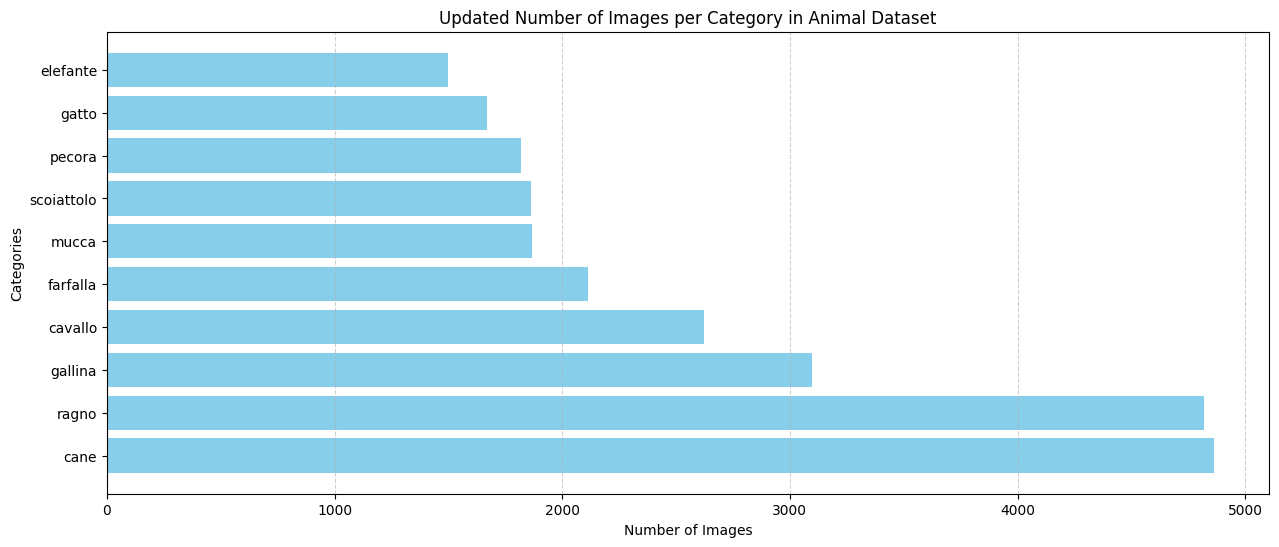

In [61]:
import os
import matplotlib.pyplot as plt

# Define dataset path
dataset_path = "/content/animal10/raw-img"

# List of categories
categories = [
  'cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo'
]

# Store category names and image counts
category_counts = []

for category in categories:
    class_path = os.path.join(dataset_path, category)

    # Count images (original + augmented)
    num_images = len([img for img in os.listdir(class_path) if img.lower().endswith(('png', 'jpg', 'jpeg'))])

    augmented_path = os.path.join(class_path, "augmented")
    if os.path.exists(augmented_path):
        num_images += len([img for img in os.listdir(augmented_path) if img.lower().endswith(('png', 'jpg', 'jpeg'))])

    category_counts.append((category, num_images))

# Sort categories by image count
category_counts.sort(key=lambda x: x[1], reverse=True)

# Extract category names and counts
categories_sorted, counts_sorted = zip(*category_counts)

# Plot the updated graph
plt.figure(figsize=(15, 6))
plt.barh(categories_sorted, counts_sorted, color="skyblue")
plt.xlabel("Number of Images")
plt.ylabel("Categories")
plt.title("Updated Number of Images per Category in Animal Dataset")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

In [62]:
import os
import shutil

# Define the dataset root
dataset_path = "animal10"

# Iterate through each class folder
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)

    # Check if it's a directory (i.e., a class folder)
    if os.path.isdir(class_path):
        augmented_path = os.path.join(class_path, "augmented")

        # If "augmented" folder exists, move images
        if os.path.exists(augmented_path):
            print(f"📂 Moving images from: {augmented_path}")

            # Move all images from "augmented" to the main class folder
            for img in os.listdir(augmented_path):
                img_path = os.path.join(augmented_path, img)
                if img.endswith(('.png', '.jpg', '.jpeg')):  # Ensure only image files are moved
                    shutil.move(img_path, os.path.join(class_path, img))

            # Remove the empty "augmented" folder
            os.rmdir(augmented_path)
            print(f"✅ Removed empty folder: {augmented_path}")

print("🎯 All augmented images moved, and 'augmented' subfolders deleted successfully!")

🎯 All augmented images moved, and 'augmented' subfolders deleted successfully!


In [63]:
import os

def print_directory_structure(root_dir, level=0):
    """ Recursively prints the directory structure and file counts. """
    if not os.path.exists(root_dir):
        print(f"❌ Path '{root_dir}' does not exist!")
        return

    # Iterate through the root directory
    for item in sorted(os.listdir(root_dir)):
        item_path = os.path.join(root_dir, item)

        # Check if it's a folder
        if os.path.isdir(item_path):
            num_files = len([f for f in os.listdir(item_path) if f.endswith(('.png', '.jpg', '.jpeg', '.PNG', '.JPG'))])
            print(" " * (level * 4) + f"📁 {item}: {num_files} images")

            # Recursively print subdirectories
            print_directory_structure(item_path, level + 1)

# Set the dataset directory
dataset_path = "animal10"

# Print the directory structure
print(f"\n📂 Directory Structure of: {dataset_path}\n")
print_directory_structure(dataset_path)


📂 Directory Structure of: animal10

📁 raw-img: 0 images
    📁 cane: 4863 images
    📁 cavallo: 2623 images
        📁 augmented: 0 images
    📁 elefante: 1446 images
        📁 augmented: 54 images
    📁 farfalla: 2112 images
        📁 augmented: 0 images
    📁 gallina: 3098 images
        📁 augmented: 0 images
    📁 gatto: 1668 images
        📁 augmented: 0 images
    📁 mucca: 1866 images
        📁 augmented: 0 images
    📁 pecora: 1820 images
        📁 augmented: 0 images
    📁 ragno: 4821 images
        📁 augmented: 0 images
    📁 scoiattolo: 1862 images
        📁 augmented: 0 images


In [64]:
import os
import shutil
import random

import os
import shutil
import random

# Define paths
dataset_dir = "animal10/raw-img"  # Adjusted to match your actual dataset structure
train_dir = "animal10_Split/train"
test_dir = "animal10_Split/test"

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define split ratio
split_ratio = 0.8  # 80% train, 20% test

# Iterate over each class folder
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)

    if os.path.isdir(class_path):  # Check if it's a valid class folder
        images = [img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]
        random.shuffle(images)  # Shuffle for randomness

        split_index = int(len(images) * split_ratio)
        train_images, test_images = images[:split_index], images[split_index:]

        # Create class subdirectories
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Copy files (not directories)
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

print("Dataset successfully split into Train and Test sets!")


Dataset successfully split into Train and Test sets!


In [66]:
import os

def check_directory_structure(root_dir):
    print(f"\n📂 Directory Structure of: {root_dir}\n")

    if not os.path.exists(root_dir):
        print(f"❌ Error: {root_dir} does not exist.")
        return

    for class_name in sorted(os.listdir(root_dir)):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            print(f"📁 {class_name}: {num_images} images")

# Paths to train and test directories
train_dir = "animal10_Split/train"
test_dir = "animal10_Split/test"

# Check train and test directory structures
check_directory_structure(train_dir)
check_directory_structure(test_dir)


📂 Directory Structure of: animal10_Split/train

📁 cane: 4662 images
📁 cavallo: 2520 images
📁 elefante: 1397 images
📁 farfalla: 2038 images
📁 gallina: 2967 images
📁 gatto: 1598 images
📁 mucca: 1786 images
📁 pecora: 1746 images
📁 ragno: 4633 images
📁 scoiattolo: 1782 images

📂 Directory Structure of: animal10_Split/test

📁 cane: 1745 images
📁 cavallo: 947 images
📁 elefante: 531 images
📁 farfalla: 772 images
📁 gallina: 1109 images
📁 gatto: 598 images
📁 mucca: 668 images
📁 pecora: 654 images
📁 ragno: 1742 images
📁 scoiattolo: 666 images


In [67]:
import tensorflow as tf

train_dir = "animal10_Split/train"
test_dir = "animal10_Split/test"
img_size = (224, 224)  # Adjust based on model

# Load images
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, image_size=img_size, batch_size=32, label_mode="categorical"
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, image_size=img_size, batch_size=32, label_mode="categorical"
)

Found 25129 files belonging to 10 classes.
Found 9432 files belonging to 10 classes.


# **Model Development**

Deep learning models learn to classify images by extracting patterns from pixel values. There are two main approaches:

**CNN from Scratch**

- Uses convolutional layers to extract features.

- Needs more training data and computational power.

**Transfer Learning**

- Uses a pre-trained model (e.g., ResNet, VGG16) trained on large datasets like ImageNet.

- Faster training and better accuracy.

- We only fine-tune the last layers.

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),

    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(10, activation="softmax")  # Ensure correct number of classes
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 458,698 (1.75 MB)

 Trainable params: 457,738 (1.75 MB)

 Non-trainable params: 960 (3.75 KB)

In [24]:
history = model.fit(train_data, validation_data=test_data, epochs=5)

Epoch 1/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 64s 75ms/step - accuracy: 0.3225 - loss: 1.9732 - val_accuracy: 0.4953 - val_loss: 1.4690
Epoch 2/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 63s 63ms/step - accuracy: 0.5234 - loss: 1.3889 - val_accuracy: 0.2324 - val_loss: 3.4951
Epoch 3/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 47s 71ms/step - accuracy: 0.6092 - loss: 1.1572 - val_accuracy: 0.4900 - val_loss: 1.6090
Epoch 4/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 77s 65ms/step - accuracy: 0.6577 - loss: 1.0146 - val_accuracy: 0.5795 - val_loss: 1.3012
Epoch 5/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 43s 65ms/step - accuracy: 0.6957 - loss: 0.8955 - val_accuracy: 0.5123 - val_loss: 1.6839


In [25]:
history = model.fit(train_data, validation_data=test_data, epochs=10)

Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.7405 - loss: 0.7760 - val_accuracy: 0.6006 - val_loss: 1.3169
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - accuracy: 0.7709 - loss: 0.6765 - val_accuracy: 0.3978 - val_loss: 3.3501
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.7981 - loss: 0.6033 - val_accuracy: 0.7348 - val_loss: 0.8455
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 82s 63ms/step - accuracy: 0.8329 - loss: 0.4970 - val_accuracy: 0.7094 - val_loss: 0.9368
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 87s 72ms/step - accuracy: 0.8541 - loss: 0.4410 - val_accuracy: 0.6377 - val_loss: 1.3798
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 77s 64ms/step - accuracy: 0.8714 - loss: 0.3789 - val_accuracy: 0.7813 - val_loss: 0.7626
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 42s 65ms/step - accuracy: 0.8964 - loss: 0.3120 - val_accuracy: 0.7708 - val_loss: 0.7895
Epoch 8/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.9076 - loss: 0.2721 - 

# **Performance metrics**

It helps us understand how well the model is classifying images. They guide us in diagnosing issues like overfitting, underfitting, and class imbalance.

For image classification, the most common evaluation metrics include:

- **Accuracy** – Measures the percentage of correctly classified images.
- **Confusion Matrix** – Shows how well the model distinguishes between different classes.
- **F1-Score** – A balance between Precision & Recall, useful when dealing with imbalanced classes.
- **Loss & Accuracy Curves** – Helps visualize model convergence during training.

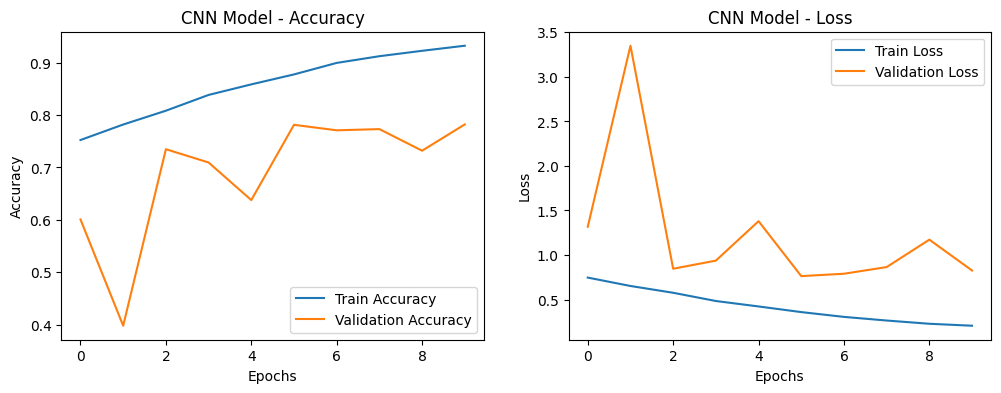

In [26]:
import matplotlib.pyplot as plt

# Extract history from CNN training
history_cnn = model.history

# Plot Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history["accuracy"], label="Train Accuracy")
plt.plot(history_cnn.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("CNN Model - Accuracy")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history["loss"], label="Train Loss")
plt.plot(history_cnn.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("CNN Model - Loss")

plt.show()


In [27]:
model.evaluate(test_data)

164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.7844 - loss: 0.8224


[0.8254169821739197, 0.782102644443512]

In [28]:
from sklearn.metrics import classification_report
import numpy as np

y_true = []
y_pred = []

for images, labels in test_data:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print(classification_report(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━

In [29]:
model.save("animal_cnn.h5")
print("Model saved successfully!")

Model saved successfully!


In [30]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("animal_cnn.h5")
print("Model loaded successfully!")

Model loaded successfully!


In [31]:
for layer in model.layers:
    print(layer.name)

conv2d
batch_normalization
max_pooling2d
conv2d_1
batch_normalization_1
max_pooling2d_1
conv2d_2
batch_normalization_2
max_pooling2d_2
conv2d_3
batch_normalization_3
max_pooling2d_3
global_average_pooling2d
dense
dropout
dense_1


164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step


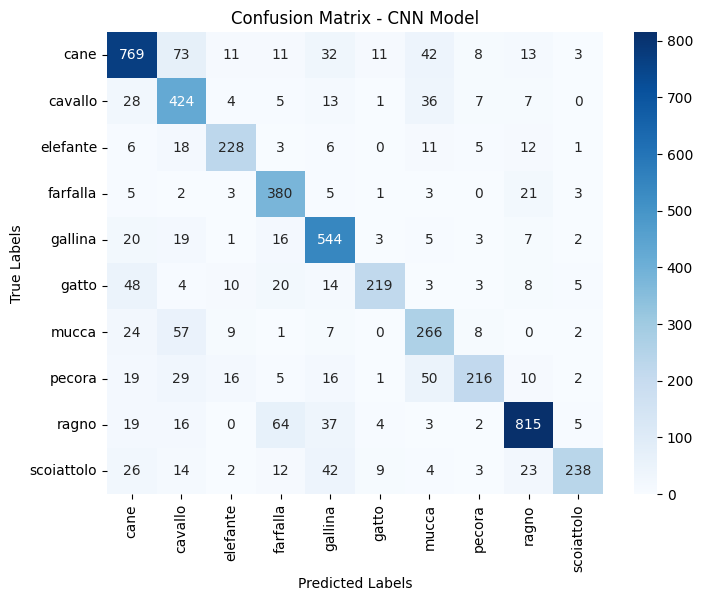

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np

# Extract images (X_test) and labels (y_test) from test dataset
X_test = []
y_test = []

for images, labels in test_data:
    X_test.append(images.numpy())   # Convert tensor to NumPy array
    y_test.append(labels.numpy())   # Convert labels to NumPy array

# Convert list to NumPy arrays
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

# Ensure X_test and y_test are defined
# If y_test is one-hot encoded, convert it to class labels
y_true = np.argmax(y_test, axis=1)  # True labels
y_pred_cnn = np.argmax(model.predict(X_test), axis=1)  # CNN model predictions

# Compute confusion matrix
cm_cnn = confusion_matrix(y_true, y_pred_cnn)
class_labels = train_data.class_names  # Extracts class names from dataset
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - CNN Model")
plt.show()

# **Explainability in Image Classification**

To interpret model decisions, Grad-CAM and Saliency Maps are used:  

- **Grad-CAM (Gradient-weighted Class Activation Mapping)** - Highlights important image regions influencing the model’s prediction by using gradients from the final convolutional layer.  
- **Saliency Maps** - Visualize pixel-level importance by computing gradients of the output class score with respect to input pixels.  
- Helps in debugging, understanding model biases, and ensuring trustworthiness in predictions.

Found 5 images. Processing...
Images selected: ['/content/animal10_Split/train/cane/OIP-xJx9XtLBNi8clvOtVFUNqwHaGO.jpeg', '/content/animal10_Split/train/cane/OIP-VkiRr2o_2S1ZN4fy9aDH3gDYEg.jpeg', '/content/animal10_Split/train/cane/OIP-ryHZvfLbR5mlf3cUquvWLQHaIa.jpeg', '/content/animal10_Split/train/cane/OIP-qKzb1ma70sVx723sozlejAHaE8.jpeg', '/content/animal10_Split/train/cane/OIP-Z_rGpjzd6pPKc8Y763vdjAHaJ4.jpeg']
Processing image: /content/animal10_Split/train/cane/OIP-xJx9XtLBNi8clvOtVFUNqwHaGO.jpeg


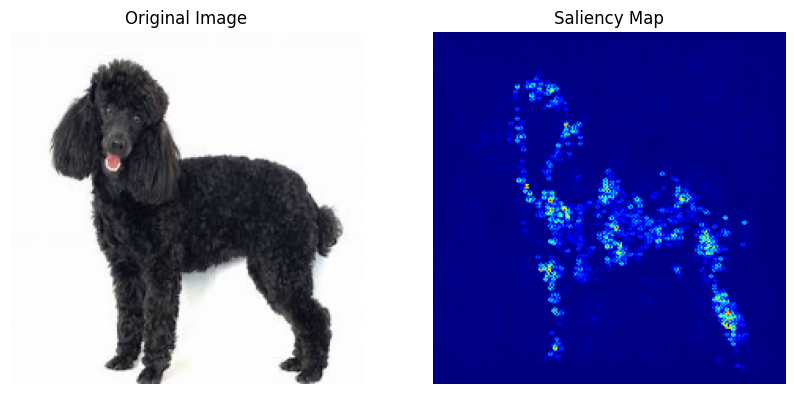

Processing image: /content/animal10_Split/train/cane/OIP-VkiRr2o_2S1ZN4fy9aDH3gDYEg.jpeg


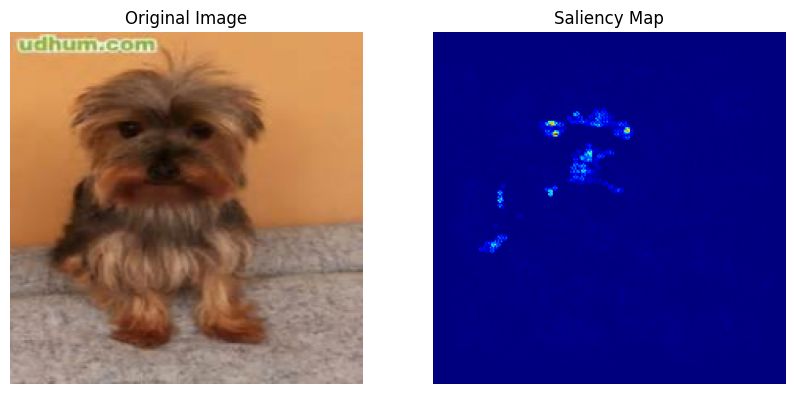

Processing image: /content/animal10_Split/train/cane/OIP-ryHZvfLbR5mlf3cUquvWLQHaIa.jpeg


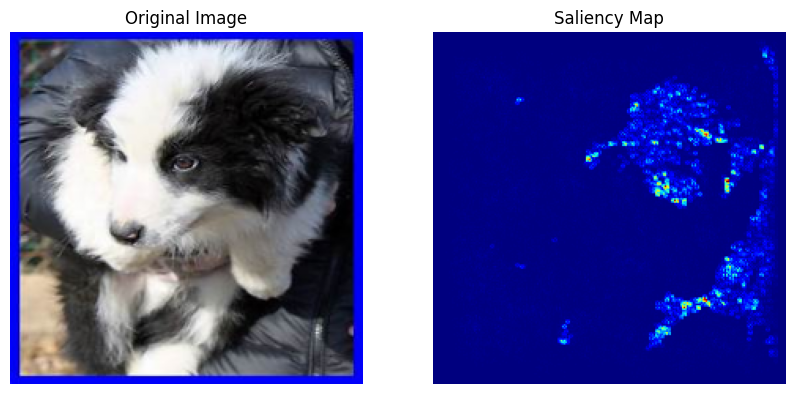

Processing image: /content/animal10_Split/train/cane/OIP-qKzb1ma70sVx723sozlejAHaE8.jpeg


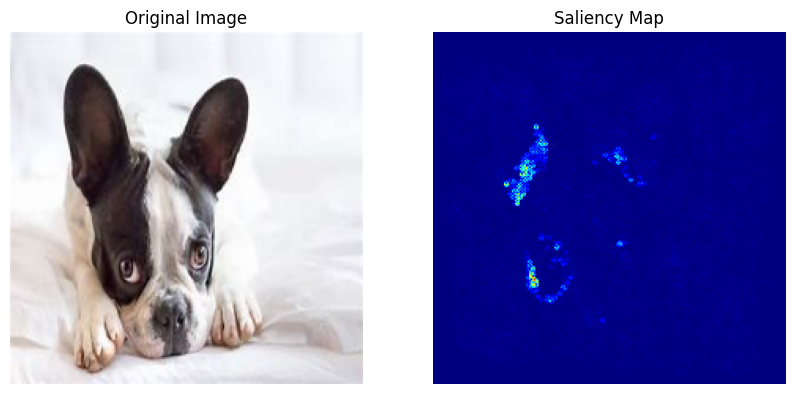

Processing image: /content/animal10_Split/train/cane/OIP-Z_rGpjzd6pPKc8Y763vdjAHaJ4.jpeg


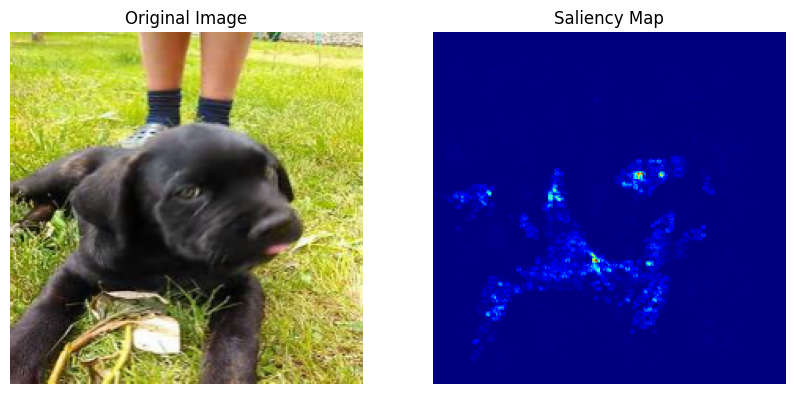

In [76]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

# Load your trained model
model_path = "animal_cnn.h5"
if not os.path.exists(model_path):
    raise ValueError(f"Model file not found: {model_path}")

model = tf.keras.models.load_model(model_path)

# Function to preprocess an image
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Error loading image: {image_path}")  # Debugging
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img, axis=0)  # Add batch dimension
    return tf.convert_to_tensor(img_array, dtype=tf.float32), img

# Get random images from a directory
def get_random_images(image_dir, num_images=5):
    if not os.path.exists(image_dir) or len(os.listdir(image_dir)) == 0:
        raise ValueError(f"No images found in directory: {image_dir}")  # Debugging

    all_images = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith((".jpg", ".jpeg"))]

    if len(all_images) == 0:
        raise ValueError("No valid images found in the directory")  # Debugging

    return random.sample(all_images, min(num_images, len(all_images)))

# Directory containing images (Update this path)
image_dir = "/content/animal10_Split/train/cane"  # Update path

# Get 5-10 random images
num_images = 5
image_paths = get_random_images(image_dir, num_images)

print(f"Found {len(image_paths)} images. Processing...")
print("Images selected:", image_paths)  # Debugging

# Generate saliency maps for each image
for image_path in image_paths:
    print(f"Processing image: {image_path}")  # Debugging

    img_tensor, original_img = preprocess_image(image_path)

    # Get model predictions
    predictions = model(img_tensor)
    class_idx = tf.argmax(predictions[0])  # Select the predicted class

    # Compute gradients of the class w.r.t the input image
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        loss = predictions[:, class_idx]  # Focus on the predicted class

    # Get the gradients
    grads = tape.gradient(loss, img_tensor)

    # Compute the absolute values and take the maximum along the color channels
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0].numpy()

    # Normalize for visualization
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    # Display the original image and the saliency map
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.axis("off")
    plt.title("Original Image")

    # Saliency Map
    plt.subplot(1, 2, 2)
    plt.imshow(saliency, cmap="jet")
    plt.axis("off")
    plt.title("Saliency Map")

    plt.show(block=True)  # Ensure images are displayed

In [77]:
import tensorflow as tf

train_dir = "animal10_Split/train"
test_dir = "animal10_Split/test"
img_size = (224, 224)  # Adjust based on model

# Load images
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, image_size=img_size, batch_size=32, label_mode="categorical"
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, image_size=img_size, batch_size=32, label_mode="categorical"
)

Found 25129 files belonging to 10 classes.
Found 9432 files belonging to 10 classes.


In [78]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define a Custom ResNet Model
def build_resnet(input_shape=(224, 224, 3), num_classes=2, use_sparsity=False):
    base_model = tf.keras.applications.ResNet50(
        weights="imagenet",  # Use pretrained weights for better performance
        input_shape=input_shape,
        include_top=False
    )

    base_model.trainable = False  # Freeze base layers initially

    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Data Augmentation (Optional)
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),

        base_model,
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])

    return model

# Detect Number of Classes
num_classes = len(train_data.class_names)  # Ensure train_data is defined

# Check if labels are sparse or one-hot encoded
use_sparsity = False  # Change to True if using sparse labels

# Create Model
input_shape = (224, 224, 3)
resnet_model = build_resnet(input_shape, num_classes, use_sparsity)

# Compile the Model
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy" if use_sparsity else "categorical_crossentropy",
    metrics=["accuracy"]
)

# Print Model Summary
resnet_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 7, 7, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,123,018 (92.02 MB)

 Trainable params: 531,210 (2.03 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [79]:
history = resnet_model.fit(train_data, epochs=10, validation_data=test_data)

Epoch 1/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 153s 180ms/step - accuracy: 0.6350 - loss: 1.1433 - val_accuracy: 0.9238 - val_loss: 0.2474
Epoch 2/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 138s 176ms/step - accuracy: 0.8401 - loss: 0.4743 - val_accuracy: 0.9402 - val_loss: 0.1930
Epoch 3/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 147s 182ms/step - accuracy: 0.8683 - loss: 0.4062 - val_accuracy: 0.9455 - val_loss: 0.1738
Epoch 4/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 142s 181ms/step - accuracy: 0.8724 - loss: 0.3878 - val_accuracy: 0.9493 - val_loss: 0.1588
Epoch 5/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 138s 176ms/step - accuracy: 0.8836 - loss: 0.3468 - val_accuracy: 0.9527 - val_loss: 0.1524
Epoch 6/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 143s 182ms/step - accuracy: 0.8880 - loss: 0.3374 - val_accuracy: 0.9550 - val_loss: 0.1443
Epoch 7/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 138s 176ms/step - accuracy: 0.8949 - loss: 0.3192 - val_accuracy: 0.9571 - val_loss: 0.1365
Epoch 8/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 138s 175ms/step - accuracy: 0.8966 -

In [80]:
resnet_model.save("resnet_model.h5")

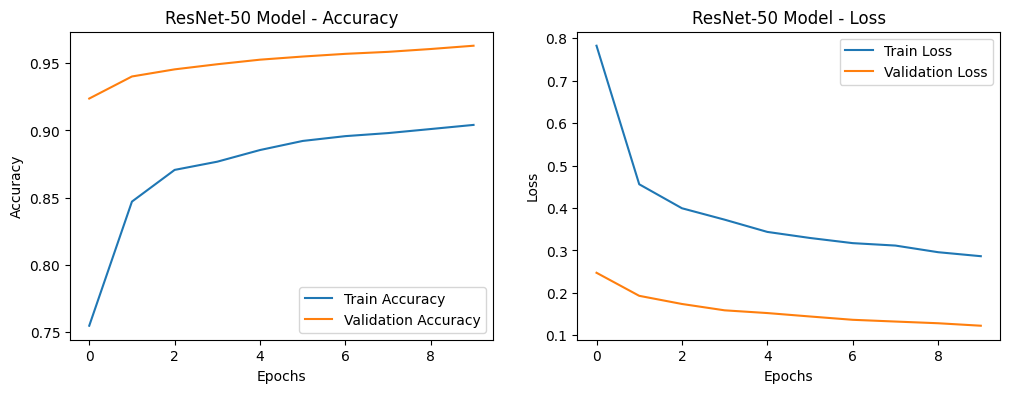

In [81]:
# Extract history from ResNet-50 training
history_resnet = resnet_model.history

# Plot Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet.history["accuracy"], label="Train Accuracy")
plt.plot(history_resnet.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("ResNet-50 Model - Accuracy")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history["loss"], label="Train Loss")
plt.plot(history_resnet.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("ResNet-50 Model - Loss")

plt.show()

In [82]:
from sklearn.metrics import classification_report
import numpy as np

y_true = []
y_pred = []

for images, labels in test_data:
    preds = resnet_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print(classification_report(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Found 9432 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


295/295 ━━━━━━━━━━━━━━━━━━━━ 44s 142ms/step


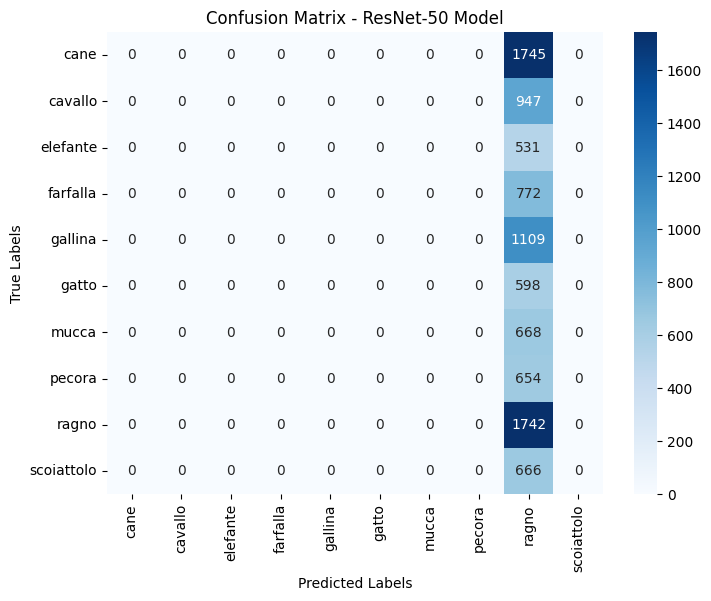

In [83]:
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load test dataset
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

test_data = test_datagen.flow_from_directory(
    "/content/animal10_Split/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",  # Ensure consistency with training data
    shuffle=False
)

# Get true labels
y_true = test_data.classes  # Directly extract class indices

# Get model predictions
y_pred_proba = resnet_model.predict(test_data)  # Predict on the generator
y_pred = np.argmax(y_pred_proba, axis=1)  # Convert softmax probabilities to class labels

# Compute confusion matrix
cm_resnet = confusion_matrix(y_true, y_pred)

# Extract class labels
class_labels = list(test_data.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_resnet, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - ResNet-50 Model")
plt.show()

In [84]:
print(resnet_model.input_shape)

(None, 224, 224, 3)


Found 9432 images belonging to 10 classes.
102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


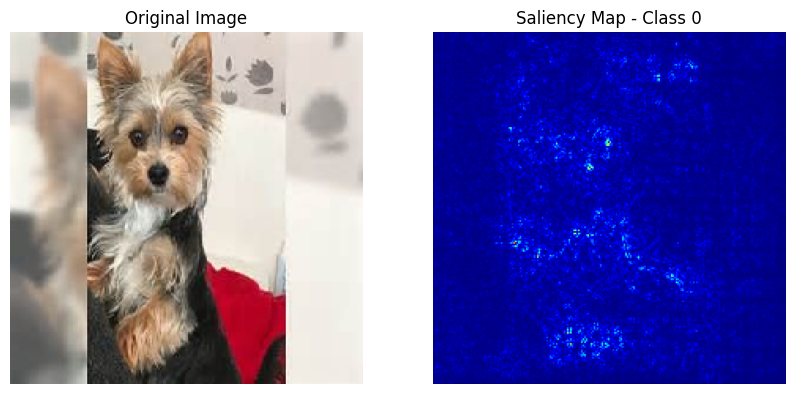

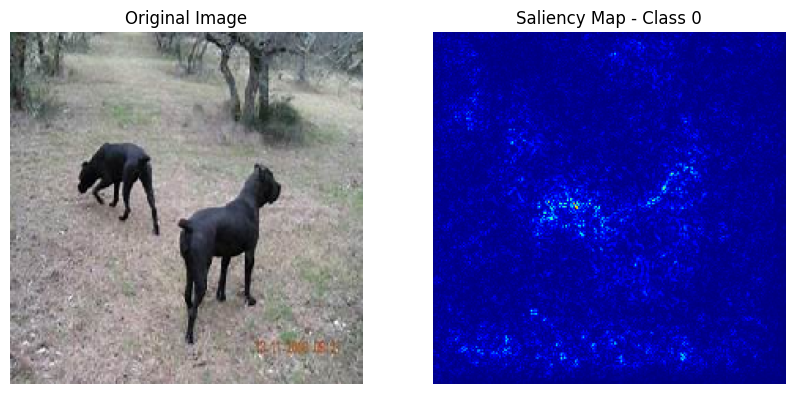

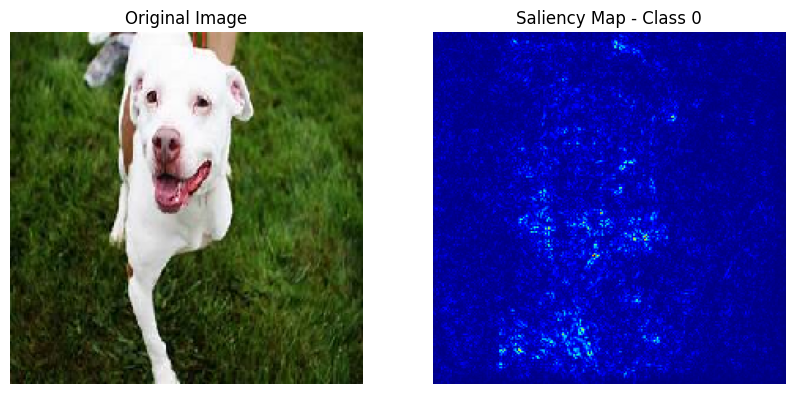

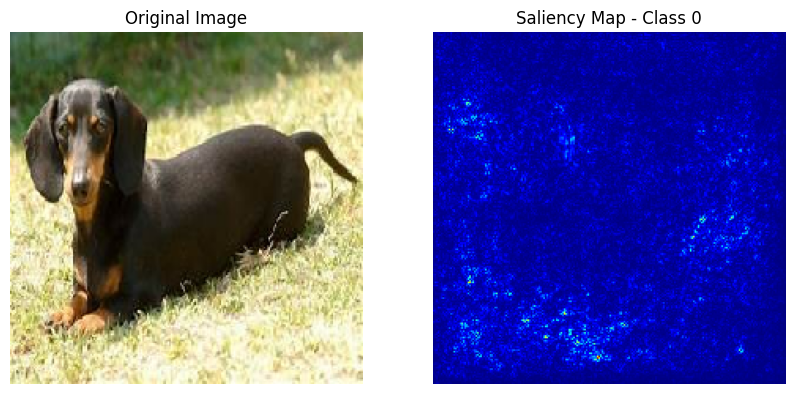

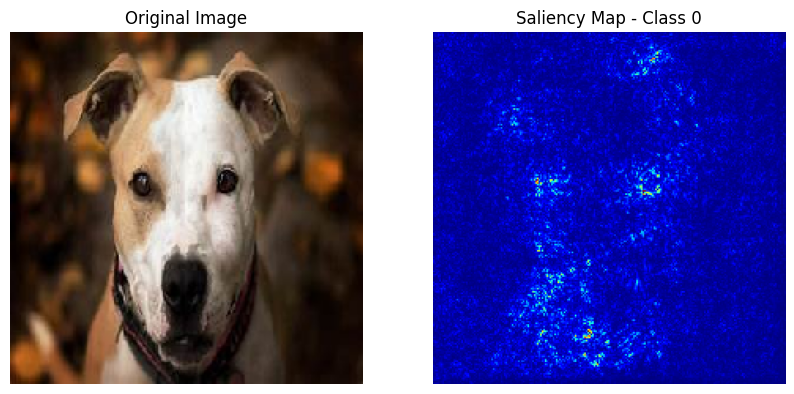

In [85]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load test dataset
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

test_data = test_datagen.flow_from_directory(
    "/content/animal10_Split/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",  # Change to "sparse" if labels are integers
    shuffle=False
)

# Load pre-trained model (Ensure it's defined)
model = tf.keras.applications.ResNet50(weights="imagenet")  # Change to your trained model

# Function to generate saliency map
def compute_saliency_map(resnet_model, image, class_index):
    image = tf.convert_to_tensor(image, dtype=tf.float32)  # Ensure it's a tensor
    image = tf.expand_dims(image, axis=0)  # Add batch dimension

    with tf.GradientTape() as tape:
        tape.watch(image)
        predictions = resnet_model(image)
        loss = predictions[:, class_index]  # Target class score

    # Compute gradients
    grads = tape.gradient(loss, image)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]  # Take max gradient across channels

    return saliency.numpy()

# Function to plot saliency map
def plot_saliency(image, saliency, title="Saliency Map"):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)  # Image should be in correct format
    ax[0].axis("off")
    ax[0].set_title("Original Image")

    ax[1].imshow(saliency, cmap="jet")
    ax[1].axis("off")
    ax[1].set_title(title)

    plt.show()

# Select random images from test dataset
num_images = 5  # Change this to 10 if needed

# Fetch images from dataset properly
for _ in range(num_images):
    image_batch, label_batch = next(test_data)  # ✅ Correct
    image = image_batch[0]  # Select first image from batch
    label = label_batch[0]  # Select corresponding label
    class_index = np.argmax(label)  # Get predicted class

    saliency = compute_saliency_map(model, image, class_index)
    plot_saliency(image, saliency, title=f"Saliency Map - Class {class_index}")